In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/Network_science/Enron_email')

In [ ]:
df = pd.read_csv("enron-email-weighted-edges.csv")

In [ ]:
df.head()

,senderID,receiverID,weight
0,1000,966,2
1,100,100,1
2,100,10756,3
3,1001,1002,1
4,1001,1077,1


In [ ]:
G = nx.DiGraph()

for index, row in df.iterrows():
    source = row['senderID']
    target = row['receiverID']
    weight = row['weight']

    G.add_node(source)
    G.add_node(target)

    G.add_edge(source, target, weight=weight)

### 2.41.1 Number of nodes and edges.

In [ ]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

edge_density = nx.density(G)

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")
print(f"Edge density: {edge_density}")

Number of nodes: 87273
Number of edges: 321918
Edge density: 4.226592977156824e-05


### 2.41.2 Strongly and weakly connected components

In [ ]:
print(f"Is G weakly connected? {nx.is_weakly_connected(G)}")

num_weakly_connected_components = nx.number_weakly_connected_components(G)
print(f"Number of weakly connected components: {num_weakly_connected_components}")

strongly_connected_components = list(nx.strongly_connected_components(G))
num_non_trivial_scc = sum(1 for scc in strongly_connected_components if len(scc) > 1)
print(f"Number of non-trivial strongly connected components: {num_non_trivial_scc}")

Is G weakly connected? False
Number of weakly connected components: 1331
Number of non-trivial strongly connected components: 38


In [ ]:
largest_scc = max(nx.strongly_connected_components(G), key=len)
print(f"Size of the largest strongly connected component: {len(largest_scc)}")

largest_wcc = max(nx.weakly_connected_components(G), key=len)
print(f"Size of the largest weakly connected component: {len(largest_wcc)}")

Size of the largest strongly connected component: 9164
Size of the largest weakly connected component: 84384


### 2.41.4 Shortest path of the largest connected components
I only did the following analyses on the largest components.

In [ ]:
largest_scc_graph = G.subgraph(largest_scc)
print(f"Number of nodes in largest SCC graph: {largest_scc_graph.number_of_nodes()}")
print(f"Number of edges in largest SCC graph: {largest_scc_graph.number_of_edges()}")
print(f"Edge density in largest SCC graph: {nx.density(largest_scc_graph)}")

Number of nodes in largest SCC graph: 9164
Number of edges in largest SCC graph: 163984
Edge density in largest SCC graph: 0.0019528941690560595


In [ ]:
largest_wcc_graph = G.subgraph(largest_wcc)
print(f"Number of nodes in largest SCC graph: {largest_wcc_graph.number_of_nodes()}")
print(f"Number of edges in largest SCC graph: {largest_wcc_graph.number_of_edges()}")
print(f"Edge density in largest SCC graph: {nx.density(largest_wcc_graph)}")

Number of nodes in largest SCC graph: 84384
Number of edges in largest SCC graph: 320010
Edge density in largest SCC graph: 4.4941594852129945e-05


In [ ]:
scc_sample_idx = random.sample(list(largest_scc_graph.nodes), 2000) # about 20% of scc nodes
scc_sample = largest_scc_graph.subgraph(scc_sample_idx)

In [ ]:
all_shortest_paths = dict(nx.shortest_path_length(scc_sample))
all_path_lengths = []
for source_node, paths_from_source in all_shortest_paths.items():
    for target_node, length in paths_from_source.items():
        if source_node != target_node: # exclude self-loops (path length 0)
            all_path_lengths.append(length)

In [ ]:
average_shortest_path = np.mean(all_path_lengths)
print(f"Average shortest path length of SCC sample: {average_shortest_path:.1f}")

Average shortest path length of SCC sample: 4.1069


In [ ]:
wcc_sample_idx = random.sample(list(largest_wcc_graph.nodes), 20000)
wcc_sample = largest_wcc_graph.subgraph(wcc_sample_idx)

In [ ]:
all_shortest_paths = dict(nx.shortest_path_length(wcc_sample))
all_path_lengths = []
for source_node, paths_from_source in all_shortest_paths.items():
    for target_node, length in paths_from_source.items():
        if source_node != target_node:
            all_path_lengths.append(length)

In [ ]:
average_shortest_path = np.mean(all_path_lengths)
print(f"Average shortest path length of WCC sample: {average_shortest_path:.4f}")

Average shortest path length of WCC sample: 4.4689


### 2.41.6 Clustering coefficient
Average Clustering Coefficient of largest SCC: 0.2868

In [ ]:
clustering_scc = np.array(list(nx.clustering(largest_scc_graph).values()))
clustering_wcc = np.array(list(nx.clustering(largest_wcc_graph).values()))

In [ ]:
def get_cumulative_distribution(data):
    sorted_data = np.sort(data)
    cumulative_counts = np.arange(1, len(sorted_data) + 1)
    cumulative_percentages = cumulative_counts / len(sorted_data)
    return sorted_data, cumulative_percentages

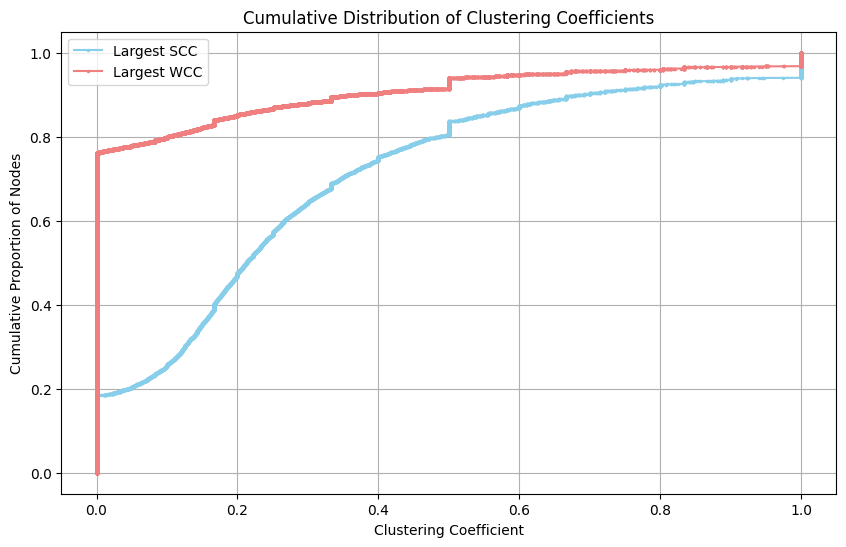

In [ ]:
clust_scc_sorted, clust_scc_cumulative = get_cumulative_distribution(clustering_scc)
clust_wcc_sorted, clust_wcc_cumulative = get_cumulative_distribution(clustering_wcc)

plt.figure(figsize=(10, 6))
plt.plot(clust_scc_sorted, clust_scc_cumulative, marker='.', linestyle='-', label='Largest SCC', color='skyblue', markersize=3)
plt.plot(clust_wcc_sorted, clust_wcc_cumulative, marker='.', linestyle='-', label='Largest WCC', color='lightcoral', markersize=3)
plt.title('Cumulative Distribution of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Cumulative Proportion of Nodes')
plt.legend()
plt.grid(True)
plt.show()

# interetingly there seems to be a jump in clustering coefficent every 0.16 value apart.
# It's like there are layers for the communication bubbles, and the cloer to the core, the deeper into the inner circle.

In [ ]:
avg_clustering_scc = np.average(clustering_scc)
avg_clustering_wcc = np.average(clustering_wcc)

print(f"Average Clustering Coefficient of largest SCC: {avg_clustering_scc:.4f}")
print(f"Average Clustering Coefficient of largest WCC: {avg_clustering_wcc:.4f}")

Average Clustering Coefficient of largest SCC: 0.2868
Average Clustering Coefficient of largest WCC: 0.0942


### 2.41.7 Degree assortativity for digraph:

The `degree_assortativitty_coefficent` from `networkx` is calculated as follows:
1.   calculate mixing matrix $M$ such that $M_{ij}$ represents the number of edges from nodes with property $i$ to $j$. It is normalized by the total number of ordered edges, $e = \frac{M}{|E|}$.
2.   calculate the Pearson correlation coefficients of r(in, in), r(in, out), r(out, in), r(out, out) as
$$r(x,y) = \frac{\sum\limits_{i,j}P_i P_j(e_{ij} -a_i b_j)}{\sigma_a\sigma_b}$$

     where    
     $x,y \in$ \{in,out\}   
     $P_i$, $P_j$ are the numerical property (degrees) of different groups of in and out degrees,   
     $a[i] = \sum\limits_{j}e[i][j]$, the sum of edges start with nodes of certain degree.   
     $b[i] = \sum\limits_{j}e[j][i]$, the sum of edges that end with nodes of certain degree.


Without considering edge weights   
The largest strongly connected component have subtle out-in and out-out degree disassortativity, which means that nodes with higher out degree are more likely to send emails to nodes with lower in degree, and out degree.   
The largest weakly connected component also have subtle out-in degree disassortativity.

In [ ]:
scc_in_in = nx.degree_assortativity_coefficient(largest_scc_graph, "in", "in")
scc_in_out = nx.degree_assortativity_coefficient(largest_scc_graph, "in", "out")
scc_out_in = nx.degree_assortativity_coefficient(largest_scc_graph, "out", "in")
scc_out_out = nx.degree_assortativity_coefficient(largest_scc_graph, "out", "out")

print(f"Degree assortativity in-in of largest SCC graph: {scc_in_in:.4f}")
print(f"Degree assortativity in-out of largest SCC graph: {scc_in_out:.4f}")
print(f"Degree assortativity out-in of largest SCC graph: {scc_out_in:.4f}")
print(f"Degree assortativity out-out of largest SCC graph: {scc_out_out:.4f}")

Degree assortativity in-in of largest SCC graph: -0.0557
Degree assortativity in-out of largest SCC graph: -0.0366
Degree assortativity out-in of largest SCC graph: -0.1446
Degree assortativity out-out of largest SCC graph: -0.1085


In [ ]:
wcc_in_in = nx.degree_assortativity_coefficient(largest_wcc_graph, "in", "in")
wcc_in_out = nx.degree_assortativity_coefficient(largest_wcc_graph, "in", "out")
wcc_out_in = nx.degree_assortativity_coefficient(largest_wcc_graph, "out", "in")
wcc_out_out = nx.degree_assortativity_coefficient(largest_wcc_graph, "out", "out")

print(f"Degree assortativity in-in of largest SCC graph: {wcc_in_in:.4f}")
print(f"Degree assortativity in-out of largest SCC graph: {wcc_in_out:.4f}")
print(f"Degree assortativity out-in of largest SCC graph: {wcc_out_in:.4f}")
print(f"Degree assortativity out-out of largest SCC graph: {wcc_out_out:.4f}")

Degree assortativity in-in of largest SCC graph: -0.0198
Degree assortativity in-out of largest SCC graph: 0.0119
Degree assortativity out-in of largest SCC graph: -0.1345
Degree assortativity out-out of largest SCC graph: -0.0923


Considers edge weights   
Neither assorative or disassorative for the strongly connected component, which means that there is no correlation between the amount of emails exchanged between nodes of different degrees.

In [ ]:
scc_in_in = nx.degree_assortativity_coefficient(largest_scc_graph, "in", "in", weight="weight")
scc_in_out = nx.degree_assortativity_coefficient(largest_scc_graph, "in", "out", weight="weight")
scc_out_in = nx.degree_assortativity_coefficient(largest_scc_graph, "out", "in", weight="weight")
scc_out_out = nx.degree_assortativity_coefficient(largest_scc_graph, "out", "out", weight="weight")

print(f"Degree assortativity in-in of largest SCC graph with edge weights: {scc_in_in:.4f}")
print(f"Degree assortativity in-out of largest SCC graph with edge weights: {scc_in_out:.4f}")
print(f"Degree assortativity out-in of largest SCC graph with edge weights: {scc_out_in:.4f}")
print(f"Degree assortativity out-out of largest SCC graph with edge weights: {scc_out_out:.4f}")

Degree assortativity in-in of largest SCC graph with edge weights: -0.0277
Degree assortativity in-out of largest SCC graph with edge weights: -0.0192
Degree assortativity out-in of largest SCC graph with edge weights: -0.0470
Degree assortativity out-out of largest SCC graph with edge weights: -0.0302


### 5.27 A random network was generated with the same number of nodes and edges as the largest strongly connected component of Enron email graph.

In [ ]:
num_nodes = largest_scc_graph.number_of_nodes()
num_edges = largest_scc_graph.number_of_edges()
edge_density = nx.density(largest_scc_graph)

In [ ]:
random_G = nx.gnp_random_graph(num_nodes, edge_density, directed=True)

### 5.27.1 & 3.24.4
95th percentile of in/out degree in the random graph: 25; 95th
percentile of in degree in the original graph 68, and that of the out degree is 81.     
### 5.27.3 & 3.24.6
The degree distribution of the random graph is close to normal, very different from the right-tailed distribution of the original graph.

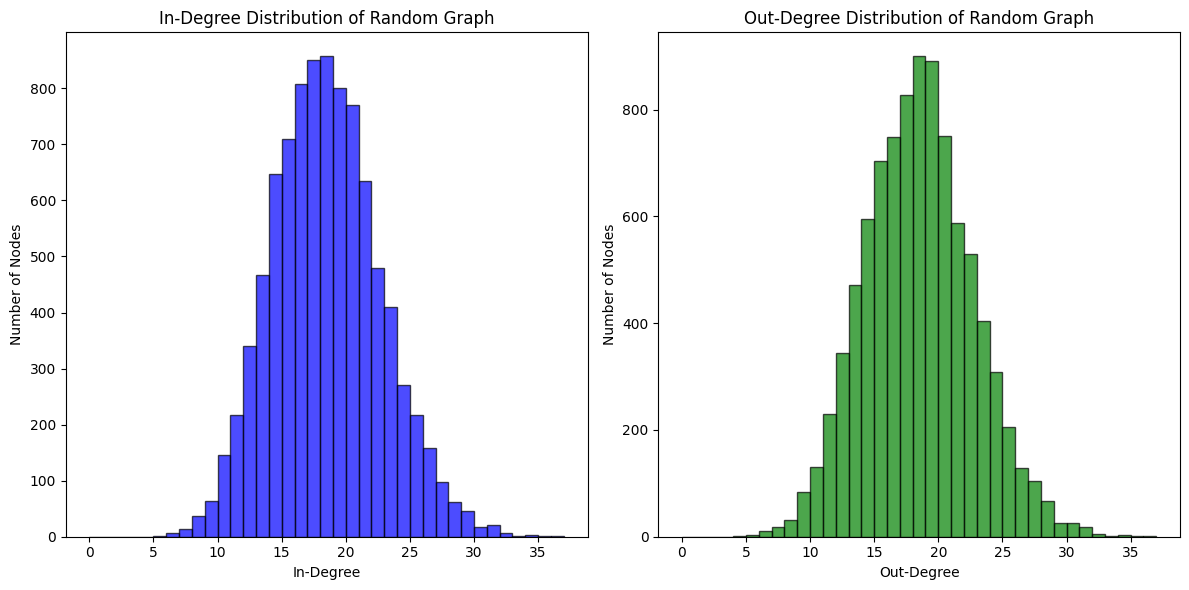

In [ ]:
in_degrees = [d for n, d in random_G.in_degree()]
out_degrees = [d for n, d in random_G.out_degree()]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), alpha=0.7, color='blue', edgecolor='black')
plt.title('In-Degree Distribution of Random Graph')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), alpha=0.7, color='green', edgecolor='black')
plt.title('Out-Degree Distribution of Random Graph')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Nodes')

plt.tight_layout()
plt.show()

In [ ]:
print(f"95th percentile of in-degree in random graph: {np.percentile(in_degrees, 95)}")
print(f"95th percentile of out-degree in random graph: {np.percentile(out_degrees, 95)}")

95th percentile of in-degree in random graph: 25.0
95th percentile of out-degree in random graph: 25.0


In [ ]:
in_degrees = [d for n, d in largest_scc_graph.in_degree()]
out_degrees = [d for n, d in largest_scc_graph.out_degree()]

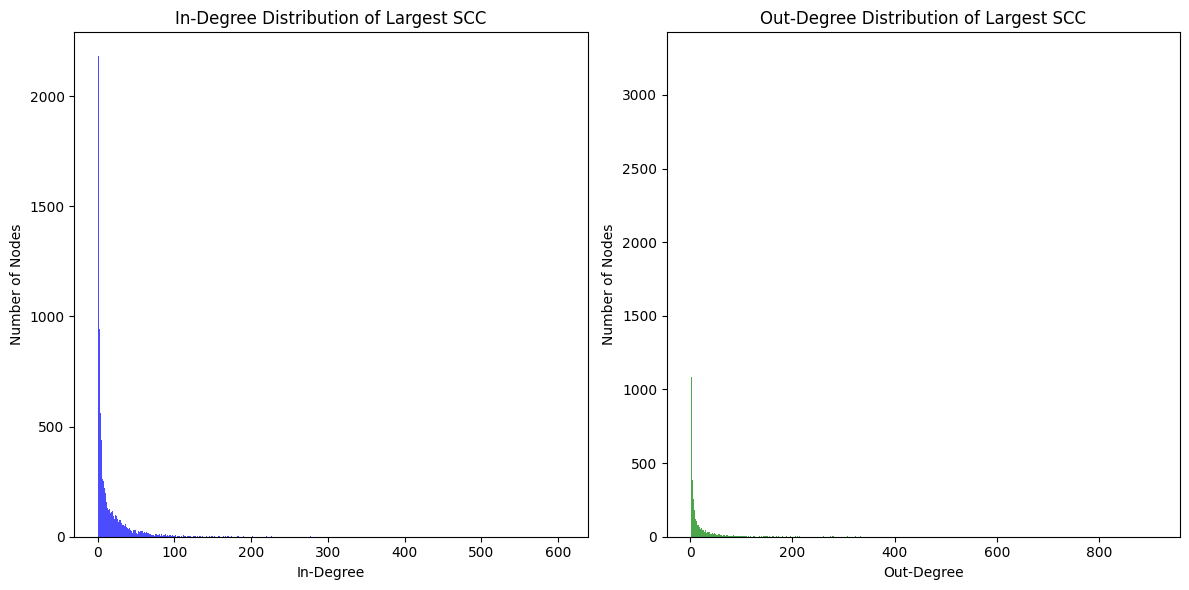

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(in_degrees, bins=range(max(in_degrees) + 2), alpha=0.7, color='blue')
plt.title('In-Degree Distribution of Largest SCC')
plt.xlabel('In-Degree')
plt.ylabel('Number of Nodes')

plt.subplot(1, 2, 2)
plt.hist(out_degrees, bins=range(max(out_degrees) + 2), alpha=0.7, color='green')
plt.title('Out-Degree Distribution of Largest SCC')
plt.xlabel('Out-Degree')
plt.ylabel('Number of Nodes')

plt.tight_layout()
plt.show()

In [ ]:
import collections

in_degree_counts = collections.Counter(in_degrees)
out_degree_counts = collections.Counter(out_degrees)

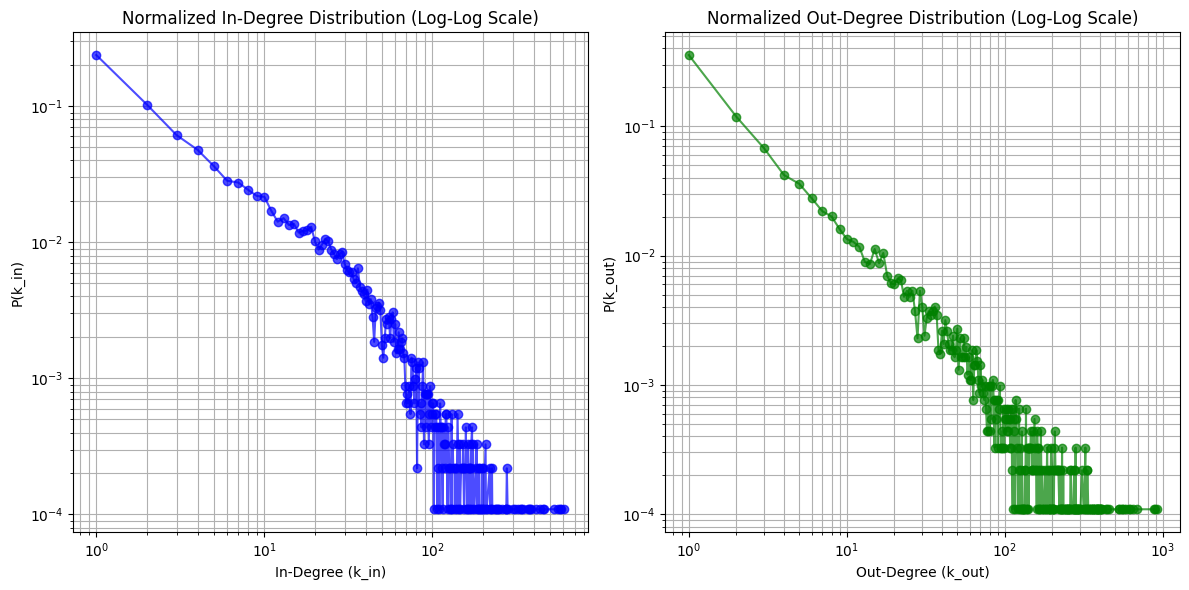

In [ ]:
total_nodes = largest_scc_graph.number_of_nodes()

in_degree_distribution = {degree: count / total_nodes for degree, count in in_degree_counts.items()}
out_degree_distribution = {degree: count / total_nodes for degree, count in out_degree_counts.items()}

sorted_in_degrees = sorted(in_degree_distribution.keys())
sorted_in_probabilities = [in_degree_distribution[d] for d in sorted_in_degrees]

sorted_out_degrees = sorted(out_degree_distribution.keys())
sorted_out_probabilities = [out_degree_distribution[d] for d in sorted_out_degrees]

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.loglog(sorted_in_degrees, sorted_in_probabilities, 'o-', color='blue', alpha=0.7)
plt.title('Normalized In-Degree Distribution (Log-Log Scale)')
plt.xlabel('In-Degree (k_in)')
plt.ylabel('P(k_in)')
plt.grid(True, which="both", ls="-")

plt.subplot(1, 2, 2)
plt.loglog(sorted_out_degrees, sorted_out_probabilities, 'o-', color='green', alpha=0.7)
plt.title('Normalized Out-Degree Distribution (Log-Log Scale)')
plt.xlabel('Out-Degree (k_out)')
plt.ylabel('P(k_out)')
plt.grid(True, which="both", ls="-")

plt.tight_layout()
plt.show()

In [ ]:
print(f"95th percentile of in-degree in SCC graph: {np.percentile(in_degrees, 95)}")
print(f"95th percentile of out-degree in SCC graph: {np.percentile(out_degrees, 95)}")

95th percentile of in-degree in SCC graph: 68.0
95th percentile of out-degree in SCC graph: 81.0


### 5.27.4
The average shortest path length of a random graph after sampling 2000 nodes: 3.5, slightly less than the average shortest path length of the largest SCC.

In [ ]:
rg_sample_idx = random.sample(list(random_G.nodes), 2000)
rg_sample = largest_scc_graph.subgraph(rg_sample_idx)

In [ ]:
all_shortest_paths = dict(nx.shortest_path_length(rg_sample))
all_path_lengths = []
for source_node, paths_from_source in all_shortest_paths.items():
    for target_node, length in paths_from_source.items():
        if source_node != target_node:
            all_path_lengths.append(length)

In [ ]:
average_shortest_path = np.mean(all_path_lengths)
print(f"Average shortest path length of random graph sample: {average_shortest_path:.4f}")

Average shortest path length of random graph sample: 3.4980


### 5.27.5 Clustering coefficient
The range of clustering coefficient distribution is much smaller than that of the original graph. Its average clustering coefficient is only 0.002.

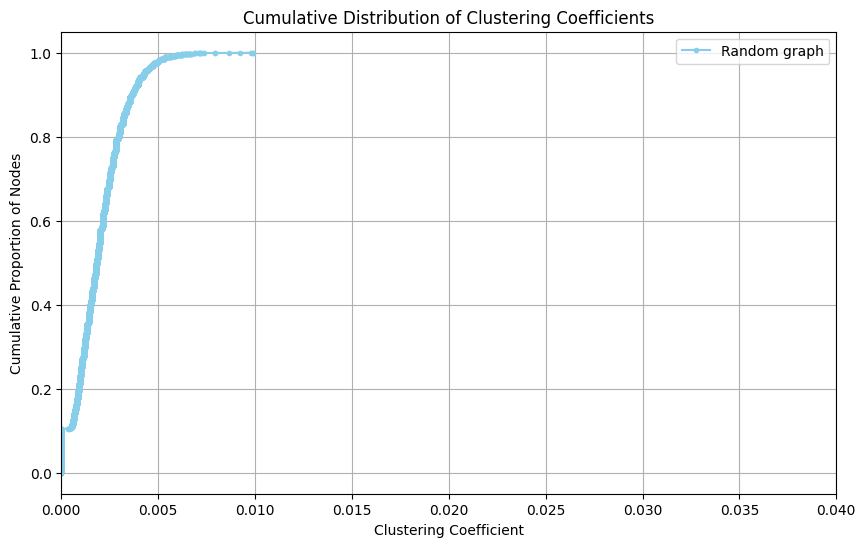

In [ ]:
clustering_rg = np.array(list(nx.clustering(random_G).values()))

clust_rg_sorted, clust_rg_cumulative = get_cumulative_distribution(clustering_rg)

plt.figure(figsize=(10, 6))
plt.plot(clust_rg_sorted, clust_rg_cumulative, marker='.', linestyle='-', label='Random graph', color='skyblue')
plt.title('Cumulative Distribution of Clustering Coefficients')
plt.xlabel('Clustering Coefficient')
plt.ylabel('Cumulative Proportion of Nodes')
plt.xlim(0,0.04)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(f"Average Clustering Coefficient of random graph: {np.average(clustering_rg):.4f}")

Average Clustering Coefficient of random graph: 0.0020
